<a href="https://colab.research.google.com/github/fxlmer/AJPom_cancer/blob/main/AJPOM_cancer_Ex1_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Check GPU

In [1]:
!nvidia-smi

Sat Feb 27 16:35:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import Libraries

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight, compute_sample_weight, compute_class_weight
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix

import pandas as pd
import numpy as np
import os
import math
import itertools
from PIL import Image
from matplotlib import pyplot as plt

from AJPom_cancer_utils import *

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from s

In [3]:
tf.compat.v1.disable_eager_execution()

# Hyperparameters

In [4]:
IMG_WIDTH = 224
IMG_HEIGHT = 224
EPOCHS = 100
BATCH_SIZE = 32
NUM_CLASSES = 2

LR = 3e-7 # Learning rate

# Data Preparation

In [5]:
!git clone https://github.com/EvilPickle-PCSHSPT/AJPom-cancer_data

Cloning into 'AJPom-cancer_data'...
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 308 (delta 1), reused 5 (delta 1), pack-reused 303
Receiving objects: 100% (308/308), 104.44 MiB | 23.23 MiB/s, done.
Resolving deltas: 100% (5/5), done.


## Split folders

In [6]:
!pip install split-folders tqdm

In [7]:
import splitfolders

In [8]:
splitfolders.ratio('/content/AJPom-cancer_data/data', 
                    output='split_data', 
                    seed=1337, 
                    ratio=(0.7, 0.1, 0.2))

Copying files: 288 files [00:00, 1973.63 files/s]


In [9]:
train_path = '/content/split_data/train' 
val_path = '/content/split_data/val'
test_path = '/content/split_data/test'

## Data Augmentation

In [10]:
train_aug = ImageDataGenerator(rescale=1./255,
                               rotation_range=360,
                               zoom_range=0.1,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               horizontal_flip=True,
                               vertical_flip=True,
                               fill_mode='reflect')

val_aug = ImageDataGenerator(rescale=1./255)

test_aug = ImageDataGenerator(rescale=1./255)

In [11]:
train_generator = train_aug.flow_from_directory(train_path, 
                                                target_size=(IMG_WIDTH, IMG_HEIGHT), 
                                                batch_size=BATCH_SIZE, 
                                                shuffle=True,
                                                class_mode='categorical') 

val_generator = val_aug.flow_from_directory(val_path, 
                                              target_size=(IMG_WIDTH, IMG_HEIGHT), 
                                              batch_size=BATCH_SIZE, 
                                              shuffle=True,
                                              class_mode='categorical') 

test_generator = test_aug.flow_from_directory(test_path, 
                                               target_size=(IMG_WIDTH, IMG_HEIGHT), 
                                               batch_size=1, 
                                               shuffle=False,
                                               class_mode=None)

Found 200 images belonging to 2 classes.
Found 28 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


# Model

## Build Model

In [12]:
def build_model_ResNet50():
  base_model = tf.keras.applications.ResNet50(include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), weights='imagenet')
  average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
  prediction_layer = tf.keras.layers.Dense(units=NUM_CLASSES, activation='softmax', name='prediction')(average_pooling_layer)
  model = Model(inputs=base_model.input, outputs=prediction_layer)
  return model

In [13]:
model = build_model_ResNet50()

94773248/94765736 [==============================] - 1s 0us/step


In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

## Compile

In [15]:
model.compile(optimizer=Adam(LR), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Callbacks

In [16]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

model_checkpoint = ModelCheckpoint(filepath='Ex1_AJPOMcancer_ResNet50_model.h5', save_best_only=True, monitor='val_loss', mode='min')

reduce_lr_rate = ReduceLROnPlateau(monitor='val_loss', factor=0.3, min_lr=1e-7, patience=10, verbose=1, min_delta=1e-4, mode='min')

## Training

In [17]:
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=EPOCHS,
                    callbacks=[early_stop, model_checkpoint, reduce_lr_rate],
                    verbose=1)

Epoch 1/100
7/7 [==============================] - ETA: 0s - batch: 3.0000 - size: 28.5714 - loss: 0.9387 - accuracy: 0.3900

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


7/7 [==============================] - 39s 4s/step - batch: 3.0000 - size: 28.5714 - loss: 0.9387 - accuracy: 0.3900 - val_loss: 0.6247 - val_accuracy: 0.6786
Epoch 2/100
7/7 [==============================] - 2s 361ms/step - batch: 3.0000 - size: 28.5714 - loss: 0.9442 - accuracy: 0.4100 - val_loss: 0.6250 - val_accuracy: 0.6786
Epoch 3/100
7/7 [==============================] - 10s 2s/step - batch: 3.0000 - size: 28.5714 - loss: 0.9590 - accuracy: 0.3650 - val_loss: 0.6319 - val_accuracy: 0.6786
Epoch 4/100
7/7 [==============================] - 10s 2s/step - batch: 3.0000 - size: 28.5714 - loss: 0.9476 - accuracy: 0.3950 - val_loss: 0.6285 - val_accuracy: 0.6786
Epoch 5/100
7/7 [==============================] - 10s 2s/step - batch: 3.0000 - size: 28.5714 - loss: 0.9063 - accuracy: 0.4100 - val_loss: 0.6419 - val_accuracy: 0.6786
Epoch 6/100
7/7 [==============================] - 9s 1s/step - batch: 3.0000 - size: 28.5714 - loss: 0.9155 - accuracy: 0.4300 - val_loss: 0.6563 - val_ac

# Training Graph

## Accuracy

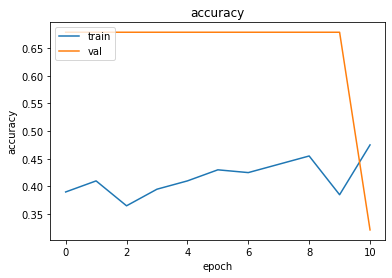

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('accuracy')
plt.show()

## Loss

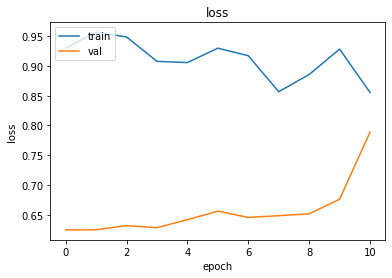

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('loss')
plt.show()

# Evaluation

In [20]:
test_model = tf.keras.models.load_model('/content/Ex1_AJPOMcancer_ResNet50_model.h5')

In [21]:
num_test_files = len(test_generator.filenames)

In [22]:
test_generator.reset()

In [23]:
test_labels = test_generator.classes
predictions = test_model.predict(test_generator, steps=num_test_files//test_generator.batch_size)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


## Confusion Matrix


### Without Normalize

Confusion matrix, without normalization
[[39  0]
 [21  0]]


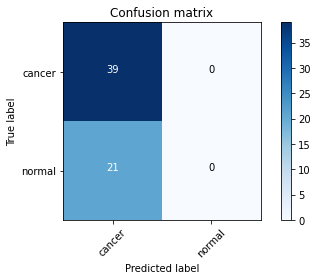

In [24]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

classes_names = ['cancer', 'normal']

plot_confusion_matrix(cm, classes_names, False)

### With Normalize

Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


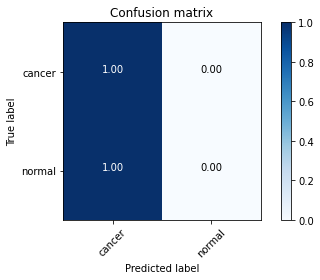

In [25]:
plot_confusion_matrix(cm, classes_names, True)

## Classification Report

In [26]:
y_pred = np.argmax(predictions, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_labels, y_pred))
print('Classification Report')
print(classification_report(test_labels, y_pred, target_names=classes_names))

Confusion Matrix
[[39  0]
 [21  0]]
Classification Report
              precision    recall  f1-score   support

      cancer       0.65      1.00      0.79        39
      normal       0.00      0.00      0.00        21

    accuracy                           0.65        60
   macro avg       0.33      0.50      0.39        60
weighted avg       0.42      0.65      0.51        60



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## TP FP FN TN

In [27]:
cm_2 = confusion_matrix(test_labels, y_pred)

### TP

In [28]:
TruePositive= np.diag(cm_2)

In [29]:
print(TruePositive)
sumTruePositive = sum(TruePositive)
print('Sum of True Positive: ', sumTruePositive)

[39  0]
Sum of True Positive:  39


### FP

In [30]:
FalsePositive = []
for i in range(NUM_CLASSES):
    FalsePositive.append(sum(cm_2[:,i]) - cm_2[i,i])

In [31]:
print(FalsePositive)
sumFalsePositive = sum(FalsePositive)
print('Sum of False Positive: ', sumFalsePositive)

[21, 0]
Sum of False Positive:  21


### FN

In [32]:
FalseNegative = []
for i in range(NUM_CLASSES):
    FalseNegative.append(sum(cm_2[i,:]) - cm_2[i,i])

In [33]:
print(FalseNegative)
sumFalseNegative = sum(FalseNegative)
print('Sum of False Negative: ', sumFalseNegative)

[0, 21]
Sum of False Negative:  21


### TN

In [34]:
TrueNegative = []
for i in range(NUM_CLASSES):
    temp = np.delete(cm_2, i, 0)   # delete ith row
    temp = np.delete(temp, i, 1)  # delete ith column
    TrueNegative.append(sum(sum(temp)))

In [35]:
print(TrueNegative)
sumTrueNegative = sum(TrueNegative)
print('Sum of True Negative: ', sumTrueNegative)

[0, 39]
Sum of True Negative:  39


## Check TP + FP + FN + TN = Test set

In [36]:
l = len(test_labels)
for i in range(NUM_CLASSES):
    print(TruePositive[i] + FalsePositive[i] + FalseNegative[i] + TrueNegative[i] == l)

True
True


## PYCM

In [37]:
!pip3 install pycm==3.0 

     |████████████████████████████████| 71kB 7.2MB/s 
     |████████████████████████████████| 573kB 21.9MB/s 


In [38]:
from pycm import *

In [39]:
py_cm = ConfusionMatrix(actual_vector=test_labels, predict_vector=y_pred)

In [40]:
py_cm.classes

[0, 1]

In [41]:
py_cm.table

{0: {0: 39, 1: 0}, 1: {0: 21, 1: 0}}

In [42]:
print(py_cm)

Predict  0        1        
Actual
0        39       0        

1        21       0        





Overall Statistics : 

95% CI                                                            (0.52931,0.77069)
ACC Macro                                                         0.65
ARI                                                               0.0
AUNP                                                              0.5
AUNU                                                              0.5
Bangdiwala B                                                      0.65
Bennett S                                                         0.3
CBA                                                               0.325
CSI                                                               None
Chi-Squared                                                       None
Chi-Squared DF                                                    1
Conditional Entropy                                               -0.0
Cramer V             

### Average AUC

In [46]:
AV_AUC = (py_cm.AUC[0] + py_cm.AUC[1])/len(py_cm.AUC)

In [47]:
print('Average AUC: ', AV_AUC)

Average AUC:  0.5


### Average Sensitivity

In [44]:
AV_Sens = (py_cm.TPR[0] + py_cm.TPR[1]/len(py_cm.TPR)

SyntaxError: ignored

In [ ]:
print('Average Sensitivity: ', AV_Sens)

### Average Specificity

In [ ]:
AV_Spec = (py_cm.TNR[0] + py_cm.TNR[1]/len(py_cm.TNR)

In [ ]:
print('Average Specificity: ', AV_Spec)

## Grad-CAM

In [ ]:
last_conv2d = 'conv5_block3_3_conv'

### AKIEC

In [ ]:
akiec_img = '/content/6_classes_HAM10000_split_Ver2/images/pca-aug_train/akiec/ISIC_0026492.jpg' 

In [ ]:
 gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, akiec_img, layer_name=last_conv2d)

### BCC

In [ ]:
bcc_img = '/content/6_classes_HAM10000_split_Ver2/images/pca-aug_train/bcc/ISIC_0024332.jpg'

In [ ]:
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, bcc_img, layer_name=last_conv2d)

### BKL

In [ ]:
bkl_img = '/content/6_classes_HAM10000_split_Ver2/images/pca-aug_train/bkl/ISIC_0025548.jpg'

In [ ]:
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, bkl_img, layer_name=last_conv2d)

### DF

In [ ]:
df_img = '/content/6_classes_HAM10000_split_Ver2/images/cc_val/df/ISIC_0033626.jpg'

In [ ]:
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, df_img, layer_name=last_conv2d)

### MEL

In [ ]:
mel_img = '/content/6_classes_HAM10000_split_Ver2/images/pca-aug_train/mel/ISIC_0024516.jpg'

In [ ]:
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, mel_img, layer_name=last_conv2d)

### VASC

In [ ]:
vasc_img = '/content/6_classes_HAM10000_split_Ver2/images/cc_test/vasc/ISIC_0025452.jpg'

In [ ]:
gradcam, gb, guided_gradcam = compute_saliency(test_model, test_model, vasc_img, layer_name=last_conv2d)

# Download Model

In [ ]:
from google.colab import files

In [ ]:
files.download('/content/Ex1_HAM10000_ResNet50_Ver2_model.h5')